# this section sets up constants and imports

In [2]:
#trying a vgg16 build
from tensorflow.python.client import device_lib
device_lib.list_local_devices() 

InternalError: failed initializing StreamExecutor for CUDA device ordinal 0: Internal: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_INVALID_DEVICE

In [2]:
from theano.sandbox import cuda

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 1080 (CNMeM is disabled, cuDNN 5105)


In [6]:
import h5py
import numpy as np
import PIL

from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers import Input
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing import image
from keras.layers.normalization import BatchNormalization
from keras.preprocessing import image
from keras import optimizers
from keras import applications
from keras.callbacks import ModelCheckpoint

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
import os
import numpy as np
from glob import glob
import pandas as pd

CUR_DIR = os.getcwd()
DATA_DIR = os.path.join('/scratch', 'yns207', 'data_invasive')
W_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
print(CUR_DIR, DATA_DIR)

/home/yns207/nbs/machine_learning/invasive /scratch/yns207/data_invasive


In [4]:
path = DATA_DIR
test_path = os.path.join(path, 'test')
models_path = os.path.join(path, 'results')
train_path = os.path.join(path, 'train')
valid_path = os.path.join(path, 'valid')
batch_size = 64

# preprocesses and trains the model

In [9]:
%cd $DATA_DIR
gt = glob('train/0/*.jpg')

px_avg = np.array([]).reshape(0,3)

for f in gt:
    img = mpimg.imread(f)
    r_img = img.reshape(img.shape[0]*img.shape[1], img.shape[2])
    mean = np.mean(r_img, axis=0).reshape(1,3)
    px_avg = np.vstack((px_avg, mean))

all_img_px_avg = np.mean(px_avg, axis=0)
vgg_mean = all_img_px_avg.reshape((1,1,3))

def vgg_preprocess(x):
    x = x - vgg_mean
    return x[:, ::-1] # reverse axis rgb->bgr

print(vgg_mean)

/scratch/yns207/data_invasive
[[[ 111.32052594  121.25063492  103.65633209]]]


In [25]:
# reset model from previous run
model = None

# create the skeleton of the vgg16
inputs = Input(shape=(224,224,3))
m = Lambda(vgg_preprocess, input_shape=(224,224,3), output_shape=(224,224,3))(inputs)
m = ZeroPadding2D((1,1))(m)
m = Convolution2D(64, (3, 3), activation='relu')(m)
m = ZeroPadding2D((1,1))(m)
m = Convolution2D(64, (3, 3), activation='relu')(m)
m = MaxPooling2D((2,2), strides=(2,2))(m)

m = ZeroPadding2D((1,1))(m)
m = Convolution2D(128, (3, 3), activation='relu')(m)
m = ZeroPadding2D((1,1))(m)
m = Convolution2D(128, (3, 3), activation='relu')(m)
m = MaxPooling2D((2,2), strides=(2,2))(m)

m = ZeroPadding2D((1,1))(m)
m = Convolution2D(256, (3, 3), activation='relu')(m)
m = ZeroPadding2D((1,1))(m)
m = Convolution2D(256, (3, 3), activation='relu')(m)
m = ZeroPadding2D((1,1))(m)
m = Convolution2D(256, (3, 3), activation='relu')(m)
m = MaxPooling2D((2,2), strides=(2,2))(m)

m = ZeroPadding2D((1,1))(m)
m = Convolution2D(512, (3, 3), activation='relu')(m)
m = ZeroPadding2D((1,1))(m)
m = Convolution2D(512, (3, 3), activation='relu')(m)
m = ZeroPadding2D((1,1))(m)
m = Convolution2D(512, (3, 3), activation='relu')(m)
m = MaxPooling2D((2,2), strides=(2,2))(m)

m = ZeroPadding2D((1,1))(m)
m = Convolution2D(512, (3, 3), activation='relu')(m)
m = ZeroPadding2D((1,1))(m)
m = Convolution2D(512, (3, 3), activation='relu')(m)
m = ZeroPadding2D((1,1))(m)
m = Convolution2D(512, (3, 3), activation='relu')(m)
conv_feat = MaxPooling2D((2,2), strides=(2,2),)(m)

# ignore the top
# m = Flatten()(m)
# m = Dense(4096, activation='relu')(m)
# m = Dense(4096, activation='relu')(m)
# preds = Dense(1000, activation='softmax')(m)

base_model = Model(inputs=inputs, outputs=conv_feat)

In [26]:
base_model.load_weights(get_file('vgg16_tf_notop.h5',  W_PATH))

In [27]:
for layer in base_model.layers:
    layer.trainable = False

In [28]:
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dense(2, activation='sigmoid'))

model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 224, 224, 3)       0         
_________________________________________________________________
zero_padding2d_14 (ZeroPaddi (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_15 (ZeroPaddi (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 64)      0         
__________

In [134]:
gen = image.ImageDataGenerator()
gen_t = image.ImageDataGenerator(
        rotation_range=30, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True)

tr_batches = gen.flow_from_directory(train_path, 
                                     target_size=(224,224), 
                                     class_mode='categorical', 
                                     shuffle=True, 
                                     batch_size=batch_size)

tr_batches_aug = gen_t.flow_from_directory(train_path, 
                                     target_size=(224,224), 
                                     class_mode='categorical', 
                                     shuffle=True, 
                                     batch_size=batch_size)

va_batches = gen.flow_from_directory(valid_path, 
                                     target_size=(224,224), 
                                     class_mode='categorical', 
                                     shuffle=False, 
                                     batch_size=batch_size)

te_batches = gen.flow_from_directory(test_path, 
                                     target_size=(224,224), 
                                     class_mode='categorical', 
                                     shuffle=False, 
                                     batch_size=batch_size)

Found 1836 images belonging to 2 classes.
Found 1836 images belonging to 2 classes.
Found 459 images belonging to 2 classes.
Found 1531 images belonging to 1 classes.


In [30]:
hist = model.fit_generator(tr_batches,
                    steps_per_epoch=(tr_batches.n//batch_size)+1,
                    validation_data=va_batches,
                    validation_steps=(va_batches.n//batch_size)+1,
                    epochs=10)

Epoch 1/10
29/29 [==============================] - 59s - loss: 1.2254 - acc: 0.7629 - val_loss: 0.5025 - val_acc: 0.8791
Epoch 2/10
29/29 [==============================] - 46s - loss: 0.2951 - acc: 0.9173 - val_loss: 0.3792 - val_acc: 0.8911
Epoch 3/10
29/29 [==============================] - 46s - loss: 0.1403 - acc: 0.9524 - val_loss: 0.3588 - val_acc: 0.8922
Epoch 4/10
29/29 [==============================] - 46s - loss: 0.0810 - acc: 0.9713 - val_loss: 0.3767 - val_acc: 0.8932
Epoch 5/10
29/29 [==============================] - 46s - loss: 0.0468 - acc: 0.9872 - val_loss: 0.3585 - val_acc: 0.9009
Epoch 6/10
29/29 [==============================] - 46s - loss: 0.0311 - acc: 0.9938 - val_loss: 0.3525 - val_acc: 0.9020
Epoch 7/10
29/29 [==============================] - 46s - loss: 0.0223 - acc: 0.9981 - val_loss: 0.3522 - val_acc: 0.9031
Epoch 8/10
29/29 [==============================] - 46s - loss: 0.0176 - acc: 0.9985 - val_loss: 0.3519 - val_acc: 0.9031
Epoch 9/10
29/29 [======

In [31]:
hist.history

{'acc': [0.76171023965141615,
  0.91639433551198257,
  0.95234204896914409,
  0.97113289786320112,
  0.98747276766367731,
  0.99373638344226578,
  0.99809368191721137,
  0.99863834448629474,
  0.99972766884531594,
  1.0],
 'loss': [1.2324025130999114,
  0.2978471160048623,
  0.14020533028641038,
  0.080994462200759024,
  0.046559114520456274,
  0.031162035377586588,
  0.022181066714860257,
  0.017463743163187519,
  0.014583316493641448,
  0.012592136218721831],
 'val_acc': [0.87908496796954949,
  0.89106753916522252,
  0.89215686274509809,
  0.89324618736383443,
  0.90087145969498905,
  0.90196078431372551,
  0.90305010893246185,
  0.90305010893246185,
  0.9041394335511983,
  0.90631808278867099],
 'val_loss': [0.50254006639999504,
  0.37917894959319909,
  0.35879198313652172,
  0.37674205479656464,
  0.3585069912317369,
  0.35254891838042435,
  0.35222653594184544,
  0.35194413478370584,
  0.3521901782447866,
  0.35106778423624491]}

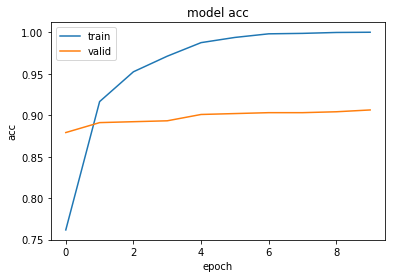

In [32]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

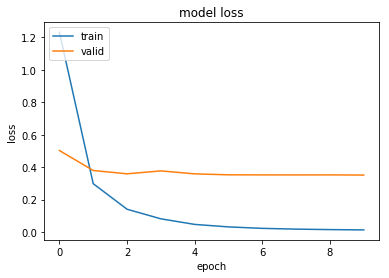

In [33]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [34]:
preds = model.predict_generator(te_batches, (te_batches.n//batch_size)+1, workers=2)
preds[:,1]

array([  1.68584927e-03,   9.80228007e-01,   1.71551891e-02, ...,
         2.43302867e-01,   1.13686502e-01,   8.94223740e-06], dtype=float32)

In [35]:
fnames = te_batches.filenames
fnames[:5]

['unknown/324.jpg',
 'unknown/47.jpg',
 'unknown/966.jpg',
 'unknown/1526.jpg',
 'unknown/487.jpg']

In [36]:
names = np.array(list(map(lambda x: x[8:].split('.')[0], fnames)))
names

array(['324', '47', '966', ..., '901', '1189', '125'], 
      dtype='<U4')

In [37]:
print(names.shape, preds[:,1].shape)

(1531,) (1531,)


In [38]:
subm_data = np.stack((names, preds[:,1]), axis=1)
subm_data.shape

(1531, 2)

In [39]:
df = pd.DataFrame(subm_data, columns=['name','invasive'])
df.head()

,name,invasive
0,324,0.001685849274508655
1,47,0.9802280068397522
2,966,0.01715518906712532
3,1526,1.2194141163490713e-05
4,487,0.8726879358291626


In [40]:
df.to_csv(os.path.join(DATA_DIR, 'results', 'subm_june_1_2017_2.gz'), index=False, compression='gzip')

In [41]:
%ls -lah $DATA_DIR/results

total 129K
drwxr-x--- 2 yns207 yns207 4,0K  1 juin  11:37 ./
drwxr-x--- 6 yns207 yns207 4,0K 26 mai   19:52 ../
-rw-r----- 1 yns207 yns207  17K  1 juin  11:37 subm_june_1_2017_2.gz
-rw-r----- 1 yns207 yns207  17K  1 juin  11:19 subm_june_1_2017.gz
-rw-r----- 1 yns207 yns207  18K 27 mai   22:36 subm_may_27_2017_2.gz
-rw-r----- 1 yns207 yns207  17K 27 mai   11:45 subm_may_27_2017.gz
-rw-r----- 1 yns207 yns207  18K 30 mai   14:04 subm_may_29_2017_.gz
-rw-r----- 1 yns207 yns207  18K 30 mai   14:56 subm_may_30_2017_2.gz
-rw-r----- 1 yns207 yns207  18K 30 mai   14:06 subm_may_30_2017.gz


the last run kind of confirms that this algorithm has a high variance in other words more optimization could help
we could also try to increase bias (beacause we cant get more data)

before running this at 10 epochs i ran it at 5 and got that score

everytime i incerase epochs by 5 i seem to get an extra .10 score

so maybe ill try for ~25 epochs, with adam should be ok

heres what to try next:

1 - adam optimizer instead of SGD

2 - learning rate speed up then slowdown after 10 epochs

3 - data augmentation

4 - batch norm + dropout on the final layers

5 - pseudo labeling to get more data since this *seems* like a high variance scenario

ps the above model is ALREADY with the mean of non-invasive images form the training set subtracted.

In [55]:
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(BatchNormalization())
top_model.add(Dense(256, activation='relu'))
top_model.add(BatchNormalization())
top_model.add(Dense(2, activation='sigmoid'))

model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=0.0001), metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
lambda_5 (Lambda)            (None, 224, 224, 3)       0         
_________________________________________________________________
zero_padding2d_53 (ZeroPaddi (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_54 (ZeroPaddi (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 112, 112, 64)      0         
__________

In [56]:
gen = image.ImageDataGenerator()
tr_batches = gen.flow_from_directory(train_path, 
                                     target_size=(224,224), 
                                     class_mode='categorical', 
                                     shuffle=True, 
                                     batch_size=batch_size)

va_batches = gen.flow_from_directory(valid_path, 
                                     target_size=(224,224), 
                                     class_mode='categorical', 
                                     shuffle=False, 
                                     batch_size=batch_size)

te_batches = gen.flow_from_directory(test_path, 
                                     target_size=(224,224), 
                                     class_mode='categorical', 
                                     shuffle=False, 
                                     batch_size=batch_size)

Found 1836 images belonging to 2 classes.
Found 459 images belonging to 2 classes.
Found 1531 images belonging to 1 classes.


In [ ]:
#try learning rate altering
#try adam instaed of SGD
#try batchnorm

In [57]:
hists = [None]*3
hists[0] = model.fit_generator(tr_batches,
                    steps_per_epoch=(tr_batches.n//batch_size)+1,
                    validation_data=va_batches,
                    validation_steps=(va_batches.n//batch_size)+1,
                    epochs=10)

Epoch 1/10
29/29 [==============================] - 59s - loss: 0.4040 - acc: 0.8229 - val_loss: 0.3874 - val_acc: 0.8954
Epoch 2/10
29/29 [==============================] - 46s - loss: 0.0973 - acc: 0.9720 - val_loss: 0.3834 - val_acc: 0.8998
Epoch 3/10
29/29 [==============================] - 46s - loss: 0.0455 - acc: 0.9955 - val_loss: 0.3506 - val_acc: 0.9031
Epoch 4/10
29/29 [==============================] - 46s - loss: 0.0292 - acc: 0.9978 - val_loss: 0.3451 - val_acc: 0.9041
Epoch 5/10
29/29 [==============================] - 46s - loss: 0.0227 - acc: 0.9978 - val_loss: 0.3385 - val_acc: 0.9052
Epoch 6/10
29/29 [==============================] - 46s - loss: 0.0148 - acc: 0.9997 - val_loss: 0.3295 - val_acc: 0.9052
Epoch 7/10
29/29 [==============================] - 46s - loss: 0.0123 - acc: 0.9996 - val_loss: 0.3282 - val_acc: 0.9074
Epoch 8/10
29/29 [==============================] - 46s - loss: 0.0087 - acc: 1.0000 - val_loss: 0.3272 - val_acc: 0.9052
Epoch 9/10
29/29 [======

In [58]:
model.optimizer.lr = 0.001
hists[1] = model.fit_generator(tr_batches,
                    steps_per_epoch=(tr_batches.n//batch_size)+1,
                    validation_data=va_batches,
                    validation_steps=(va_batches.n//batch_size)+1,
                    epochs=10)

Epoch 1/10
29/29 [==============================] - 59s - loss: 0.0055 - acc: 1.0000 - val_loss: 0.3246 - val_acc: 0.9041
Epoch 2/10
29/29 [==============================] - 46s - loss: 0.0047 - acc: 1.0000 - val_loss: 0.3254 - val_acc: 0.9031
Epoch 3/10
29/29 [==============================] - 46s - loss: 0.0049 - acc: 1.0000 - val_loss: 0.3200 - val_acc: 0.9063
Epoch 4/10
29/29 [==============================] - 46s - loss: 0.0043 - acc: 1.0000 - val_loss: 0.3239 - val_acc: 0.9041
Epoch 5/10
29/29 [==============================] - 46s - loss: 0.0033 - acc: 1.0000 - val_loss: 0.3252 - val_acc: 0.9041
Epoch 6/10
29/29 [==============================] - 46s - loss: 0.0043 - acc: 1.0000 - val_loss: 0.3261 - val_acc: 0.9020
Epoch 7/10
29/29 [==============================] - 46s - loss: 0.0050 - acc: 1.0000 - val_loss: 0.3285 - val_acc: 0.8998
Epoch 8/10
29/29 [==============================] - 46s - loss: 0.0027 - acc: 1.0000 - val_loss: 0.3266 - val_acc: 0.9041
Epoch 9/10
29/29 [======

In [59]:
model.optimizer.lr = 0.00001
hists[2] = model.fit_generator(tr_batches,
                    steps_per_epoch=(tr_batches.n//batch_size)+1,
                    validation_data=va_batches,
                    validation_steps=(va_batches.n//batch_size)+1,
                    epochs=10)

Epoch 1/10
29/29 [==============================] - 59s - loss: 0.0022 - acc: 1.0000 - val_loss: 0.3459 - val_acc: 0.9041
Epoch 2/10
29/29 [==============================] - 46s - loss: 0.0021 - acc: 1.0000 - val_loss: 0.3484 - val_acc: 0.8998
Epoch 3/10
29/29 [==============================] - 46s - loss: 0.0026 - acc: 1.0000 - val_loss: 0.3532 - val_acc: 0.8987
Epoch 4/10
29/29 [==============================] - 46s - loss: 0.0022 - acc: 1.0000 - val_loss: 0.3568 - val_acc: 0.8976
Epoch 5/10
29/29 [==============================] - 46s - loss: 0.0018 - acc: 1.0000 - val_loss: 0.3583 - val_acc: 0.8965
Epoch 6/10
29/29 [==============================] - 46s - loss: 0.0014 - acc: 1.0000 - val_loss: 0.3536 - val_acc: 0.9031
Epoch 7/10
29/29 [==============================] - 46s - loss: 0.0021 - acc: 1.0000 - val_loss: 0.3571 - val_acc: 0.8998
Epoch 8/10
29/29 [==============================] - 46s - loss: 0.0015 - acc: 1.0000 - val_loss: 0.3527 - val_acc: 0.8987
Epoch 9/10
29/29 [======

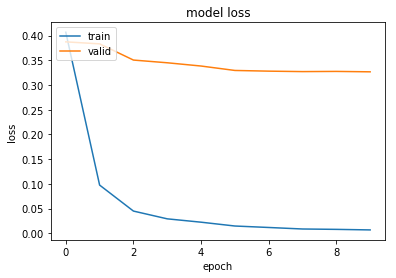

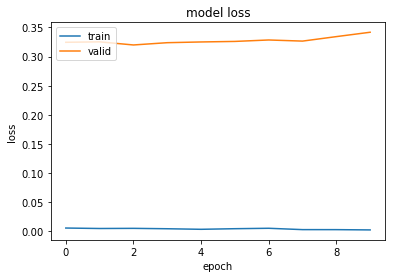

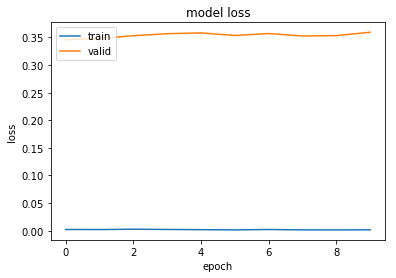

In [70]:
# plot learning curves
for i in range(3):
    plt.plot(hists[i].history['loss'])
    plt.plot(hists[i].history['val_loss'])
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

In [ ]:
# another try

In [ ]:
#lets keep all changes except learning rate changes.
#looks like with batchnorm + adam it reaches optimal in
#a few epochs
#lets also try to add dropout and pseudo labelling
#lets also try data aug
# added another layer and more dropouts/batchnorms

In [126]:
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(BatchNormalization())
top_model.add(Dense(256, activation='relu'))
top_model.add(BatchNormalization())
top_model.add(Dense(256, activation='relu'))
top_model.add(BatchNormalization())
top_model.add(Dropout(0.5))
top_model.add(Dense(2, activation='sigmoid'))

model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=0.0001), metrics=['accuracy'])

In [128]:
hist = model.fit_generator(tr_batches_aug,
                    steps_per_epoch=(tr_batches_aug.n//batch_size)+1,
                    validation_data=va_batches,
                    validation_steps=(va_batches.n//batch_size)+1,
                    epochs=10)

Epoch 1/10
29/29 [==============================] - 70s - loss: 0.6393 - acc: 0.7045 - val_loss: 0.4106 - val_acc: 0.8377
Epoch 2/10
29/29 [==============================] - 58s - loss: 0.4326 - acc: 0.8249 - val_loss: 0.3987 - val_acc: 0.8486
Epoch 3/10
29/29 [==============================] - 58s - loss: 0.3843 - acc: 0.8450 - val_loss: 0.3723 - val_acc: 0.8627
Epoch 4/10
29/29 [==============================] - 58s - loss: 0.3333 - acc: 0.8665 - val_loss: 0.3465 - val_acc: 0.8824
Epoch 5/10
29/29 [==============================] - 57s - loss: 0.2938 - acc: 0.8805 - val_loss: 0.3035 - val_acc: 0.9009
Epoch 6/10
29/29 [==============================] - 58s - loss: 0.2771 - acc: 0.8943 - val_loss: 0.2956 - val_acc: 0.9009
Epoch 7/10
29/29 [==============================] - 57s - loss: 0.2713 - acc: 0.8963 - val_loss: 0.3030 - val_acc: 0.8976
Epoch 8/10
29/29 [==============================] - 58s - loss: 0.2439 - acc: 0.9071 - val_loss: 0.2743 - val_acc: 0.9129
Epoch 9/10
29/29 [======

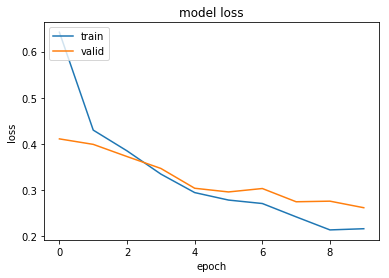

In [130]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [ ]:
#as train/valid loss keep going down together going down lets do another 10 epochs

In [131]:
hist = model.fit_generator(tr_batches_aug,
                    steps_per_epoch=(tr_batches_aug.n//batch_size)+1,
                    validation_data=va_batches,
                    validation_steps=(va_batches.n//batch_size)+1,
                    epochs=10)

Epoch 1/10
29/29 [==============================] - 70s - loss: 0.2167 - acc: 0.9215 - val_loss: 0.2506 - val_acc: 0.9227
Epoch 2/10
29/29 [==============================] - 57s - loss: 0.1954 - acc: 0.9293 - val_loss: 0.2527 - val_acc: 0.9237
Epoch 3/10
29/29 [==============================] - 57s - loss: 0.1720 - acc: 0.9363 - val_loss: 0.2388 - val_acc: 0.9259
Epoch 4/10
29/29 [==============================] - 58s - loss: 0.2003 - acc: 0.9258 - val_loss: 0.2604 - val_acc: 0.9248
Epoch 5/10
29/29 [==============================] - 57s - loss: 0.1791 - acc: 0.9358 - val_loss: 0.2584 - val_acc: 0.9227
Epoch 6/10
29/29 [==============================] - 57s - loss: 0.1797 - acc: 0.9391 - val_loss: 0.2801 - val_acc: 0.9270
Epoch 7/10
29/29 [==============================] - 57s - loss: 0.1656 - acc: 0.9375 - val_loss: 0.2783 - val_acc: 0.9259
Epoch 8/10
29/29 [==============================] - 57s - loss: 0.1750 - acc: 0.9347 - val_loss: 0.2651 - val_acc: 0.9227
Epoch 9/10
29/29 [======

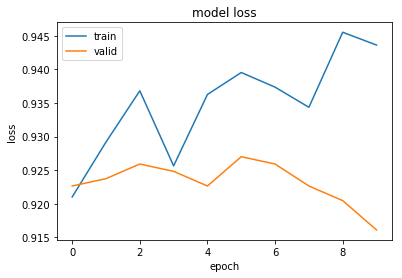

In [133]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

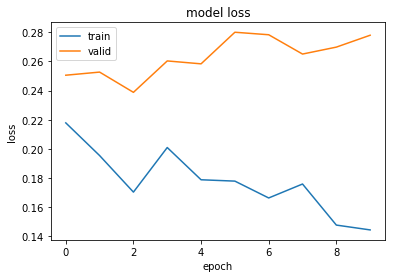

In [132]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [ ]:
# ok that looks like over fitting now.

In [ ]:
# what is it about this change (only having dropout on the last layer?) that made it better tho?
# changing the data augmentation?
#i think the models before had too much bias (one hidden layer on top, too many dropouts early on losing information)
# now we have two layers and we wait until the last layer to dropout/generalize
# ok lets try a smaller batch size maybe 32 instaed of 64

In [135]:
# ik lets try something else, 1 incraese hidden features to 1024 from conv net
# decrease bathc size, dropout half the features, we may just need psuedo label
# because we are overfitting, and have high variance
batch_size = 32

top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(BatchNormalization())
top_model.add(Dense(1024, activation='relu'))
top_model.add(BatchNormalization())
top_model.add(Dropout(0.5))
top_model.add(Dense(256, activation='relu'))
top_model.add(BatchNormalization())
top_model.add(Dense(2, activation='sigmoid'))

model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=0.0001), metrics=['accuracy'])

In [136]:
hist = model.fit_generator(tr_batches_aug,
                    steps_per_epoch=(tr_batches_aug.n//batch_size)+1,
                    validation_data=va_batches,
                    validation_steps=(va_batches.n//batch_size)+1,
                    epochs=10)

Epoch 1/10
58/58 [==============================] - 137s - loss: 0.4142 - acc: 0.8142 - val_loss: 0.3608 - val_acc: 0.8831
Epoch 2/10
58/58 [==============================] - 117s - loss: 0.2703 - acc: 0.9024 - val_loss: 0.3600 - val_acc: 0.8917
Epoch 3/10
58/58 [==============================] - 118s - loss: 0.2194 - acc: 0.9187 - val_loss: 0.3263 - val_acc: 0.9005
Epoch 4/10
58/58 [==============================] - 117s - loss: 0.1957 - acc: 0.9291 - val_loss: 0.3112 - val_acc: 0.9057
Epoch 5/10
58/58 [==============================] - 118s - loss: 0.1710 - acc: 0.9332 - val_loss: 0.2985 - val_acc: 0.9157
Epoch 6/10
58/58 [==============================] - 117s - loss: 0.1680 - acc: 0.9412 - val_loss: 0.2772 - val_acc: 0.9163
Epoch 7/10
58/58 [==============================] - 117s - loss: 0.1478 - acc: 0.9450 - val_loss: 0.2779 - val_acc: 0.9163
Epoch 8/10
58/58 [==============================] - 117s - loss: 0.1392 - acc: 0.9498 - val_loss: 0.2339 - val_acc: 0.9280
Epoch 9/10
58/58

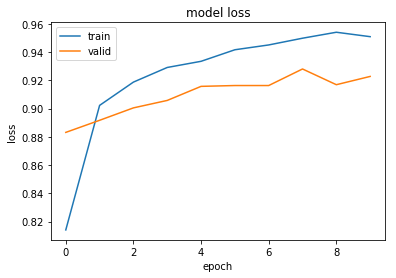

In [137]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

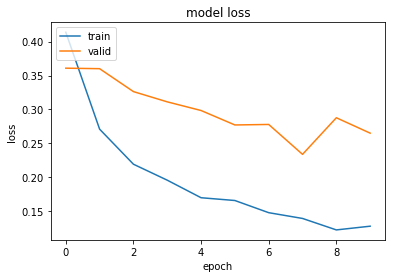

In [138]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [139]:
# lets just try training a little slow, validation lss gets unstable and starts jumping around
# indiactes maybe a slower rate
model.optimizer.lr = 0.00001
hist = model.fit_generator(tr_batches_aug,
                    steps_per_epoch=(tr_batches_aug.n//batch_size)+1,
                    validation_data=va_batches,
                    validation_steps=(va_batches.n//batch_size)+1,
                    epochs=5)

Epoch 1/5
58/58 [==============================] - 136s - loss: 0.1117 - acc: 0.9636 - val_loss: 0.3062 - val_acc: 0.9133
Epoch 2/5
58/58 [==============================] - 118s - loss: 0.1116 - acc: 0.9603 - val_loss: 0.2546 - val_acc: 0.9280
Epoch 3/5
58/58 [==============================] - 118s - loss: 0.1272 - acc: 0.9518 - val_loss: 0.2682 - val_acc: 0.9221
Epoch 4/5
58/58 [==============================] - 118s - loss: 0.0952 - acc: 0.9633 - val_loss: 0.2636 - val_acc: 0.9286
Epoch 5/5
58/58 [==============================] - 118s - loss: 0.1028 - acc: 0.9607 - val_loss: 0.2670 - val_acc: 0.9256


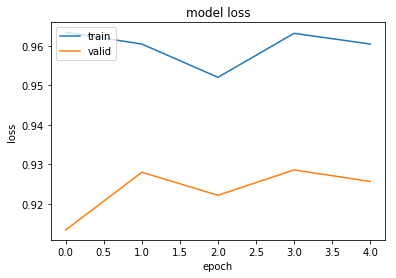

In [140]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

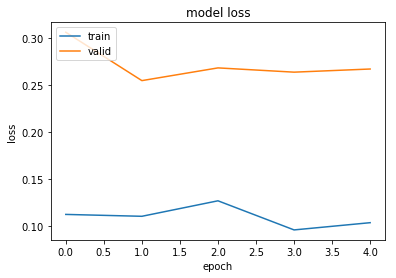

In [141]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [ ]:
# ok looks like weve pushed that to the limit buttt
# the validation and training loss are moving in sync (more or less)
# so it looks like this isnt overfitting toooo bad

In [ ]:
# i think next we should uh look to see the ones were misclassifying.
# could also try changing input resolutions (to a bigger res 400 X 300 as specified in forum)
# could also try segmenting the image classifying segments and taking the highest prediction as
# the prediciton for the whole image, this has the effect of essentially craeting *more* data

In [ ]:
#submission #5 was awful, lowest score yet.... even tho seems like best model yet.

In [ ]:
# ok ok we could also try retraining come of the later conv layers might be interesting.
# could also try a simpler conv net.

In [ ]:
# ill try to replicate forums 50 epoch training while im doing other stuff

In [176]:
img_rows, img_cols, img_channel = 224, 224, 3
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, img_channel))
add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(256, activation='relu'))
add_model.add(Dense(2, activation='softmax'))

model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),metrics=['accuracy'])

In [165]:
batch_size=32
epochs=50

hist = model.fit_generator(
    tr_batches_aug,
    steps_per_epoch=(tr_batches_aug.n//batch_size)+1,
    validation_data=va_batches,
    validation_steps=(va_batches.n//batch_size)+1,
    epochs=epochs,
    callbacks=[ModelCheckpoint('VGG16-transferlearning.model', monitor='val_acc', save_best_only=True)]
)

Epoch 1/50
58/58 [==============================] - 228s - loss: 0.9369 - acc: 0.8090 - val_loss: 0.1509 - val_acc: 0.9415
Epoch 2/50
58/58 [==============================] - 201s - loss: 0.1781 - acc: 0.9358 - val_loss: 0.1889 - val_acc: 0.9274
Epoch 3/50
58/58 [==============================] - 202s - loss: 0.1385 - acc: 0.9476 - val_loss: 0.0990 - val_acc: 0.9660
Epoch 4/50
58/58 [==============================] - 202s - loss: 0.1225 - acc: 0.9540 - val_loss: 0.0809 - val_acc: 0.9707
Epoch 5/50
58/58 [==============================] - 200s - loss: 0.0854 - acc: 0.9682 - val_loss: 0.0856 - val_acc: 0.9696
Epoch 6/50
58/58 [==============================] - 200s - loss: 0.0927 - acc: 0.9673 - val_loss: 0.0704 - val_acc: 0.9696
Epoch 7/50
58/58 [==============================] - 200s - loss: 0.0906 - acc: 0.9670 - val_loss: 0.1006 - val_acc: 0.9707
Epoch 8/50
58/58 [==============================] - 199s - loss: 0.0663 - acc: 0.9786 - val_loss: 0.0730 - val_acc: 0.9707
Epoch 9/50
58/58

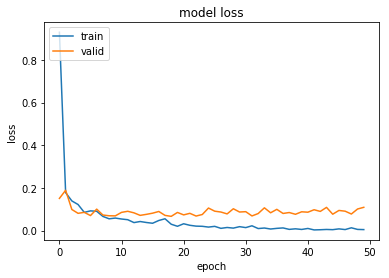

In [166]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [ ]:
model.load_weights(os.path.join(DATA_DIR, 'VGG16-transferlearning.model'))

In [178]:
batch_size=64
preds = model.predict_generator(te_batches, (te_batches.n//batch_size)+1, workers=2)
preds[:,1]

array([  9.99999881e-01,   1.00000000e+00,   2.03645602e-03, ...,
         1.00000000e+00,   9.99999881e-01,   1.97031099e-04], dtype=float32)

In [179]:
fnames = te_batches.filenames
fnames[:5]

['unknown/324.jpg',
 'unknown/47.jpg',
 'unknown/966.jpg',
 'unknown/1526.jpg',
 'unknown/487.jpg']

In [180]:
names = np.array(list(map(lambda x: x[8:].split('.')[0], fnames)))
names

array(['324', '47', '966', ..., '901', '1189', '125'], 
      dtype='<U4')

In [181]:
print(names.shape, preds[:,1].shape)

(1531,) (1531,)


In [182]:
subm_data = np.stack((names, preds[:,1]), axis=1)
subm_data.shape

(1531, 2)

In [183]:
df = pd.DataFrame(subm_data, columns=['name','invasive'])
df.head()

,name,invasive
0,324,0.9999998807907104
1,47,1.0
2,966,0.0020364560186862946
3,1526,0.0007167837466113269
4,487,1.0


In [184]:
df.to_csv(os.path.join(DATA_DIR, 'results', 'subm_june_2_2017.gz'), index=False, compression='gzip')

In [185]:
%ls -lah $DATA_DIR/results

total 225K
drwxr-x--- 2 yns207 yns207 4,0K  2 juin  09:07 ./
drwxr-x--- 6 yns207 yns207 4,0K  1 juin  20:55 ../
-rw-r----- 1 yns207 yns207  17K  1 juin  11:37 subm_june_1_2017_2.gz
-rw-r----- 1 yns207 yns207  19K  1 juin  16:07 subm_june_1_2017_3.gz
-rw-r----- 1 yns207 yns207  19K  1 juin  16:58 subm_june_1_2017_4.gz
-rw-r----- 1 yns207 yns207  19K  1 juin  20:34 subm_june_1_2017_5.gz
-rw-r----- 1 yns207 yns207  14K  1 juin  23:58 subm_june_1_2017_6.gz
-rw-r----- 1 yns207 yns207  17K  1 juin  11:19 subm_june_1_2017.gz
-rw-r----- 1 yns207 yns207  14K  2 juin  09:07 subm_june_2_2017.gz
-rw-r----- 1 yns207 yns207  18K 27 mai   22:36 subm_may_27_2017_2.gz
-rw-r----- 1 yns207 yns207  17K 27 mai   11:45 subm_may_27_2017.gz
-rw-r----- 1 yns207 yns207  18K 30 mai   14:04 subm_may_29_2017_.gz
-rw-r----- 1 yns207 yns207  18K 30 mai   14:56 subm_may_30_2017_2.gz
-rw-r----- 1 yns207 yns207  18K 30 mai   14:06 subm_may_30_2017.gz
